In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
from Bio import AlignIO
import time as time

In [3]:
#Open positive control simulated sequences
starttime = time.time()
simalign_file = '../../../data_RFAM/glnAsim_100k.sto'
X_pos = mf.sto_onehot(simalign_file, 'rna')
X_pos = np.expand_dims(X_pos, axis=2)
print (time.time() - starttime)

50.4781110287


In [5]:
#Make negative controls
starttime = time.time()
num_data, seq_length, _, dims = X_pos.shape
dims = dims-1
SS = mf.getSSconsensus(simalign_file)
X_neg = mf.seq_generator_gaps(SS, num_data, seq_length, dims)
print (time.time() - starttime)

45.9538650513


In [32]:
#Set up data dictionaries
Y_pos = np.ones((num_data, 1))*1.
Y_neg = np.ones((num_data, 1))*0.

X_data = np.concatenate((X_pos, X_neg), axis=0)
Y_data = np.concatenate((Y_pos, Y_neg), axis=0)

ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.2
valid_frac = 0.1
N = X_data.shape[0]
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = split_1 + int(N*(valid_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}


In [33]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/glnA'
param_path = os.path.join(save_path, 'resbind')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 893, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: den

In [37]:
# initialize session
sess.close()
sess = utils.initialize_session()

In [36]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=10, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=16.67s -- loss=0.00263 -- acc=100.00000%  
 
  valid loss:		0.00204
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=16.69s -- loss=0.00157 -- acc=100.00000%  
 
  valid loss:		0.00114
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=16.77s -- loss=0.00089 -- acc=100.00000%  
 
  valid loss:		0.00067
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/glnA/resbind_best.ckpt
Epoch 4 out of 100 
[==============================] 100.0% -- elapsed time=17.06s -- loss=0.00041 -- acc=100.00000%  
 
  valid loss:		0.00024
  valid accurac

In [38]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/glnA/resbind_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/glnA/resbind_best.ckpt
  test  loss:		0.00002
  test  accuracy:	1.00000+/-0.00000
  test  auc-roc:	1.00000+/-0.00000
  test  auc-pr:		1.00000+/-0.00000


In [39]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


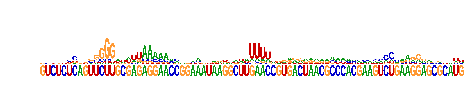

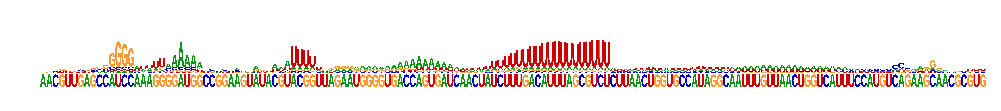

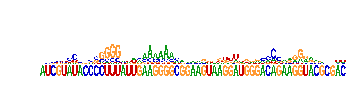

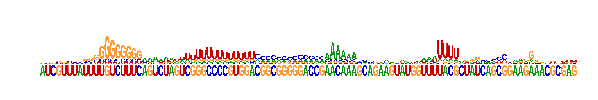

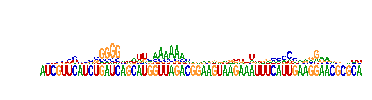

In [42]:
numplots=5

for ii in range(numplots): 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))
    

In [43]:
SS

'.....:.........:....(..(.....(...(....(......,....<...<....<....<...<....<...<.................................................................._........_....._....._......_......................................................................................................................................>.....>....>....>...>....>....>.....,.......,.......,.......,.....,......,......,.....,....<....<...<.....<......................................................._........_........_....._........_.......................................................................................................................................................................................................................................................................................................>....>.....>....>....,.....,....,.....,......)....)...)...)....).....:....:.....:.....:........'